# ✤Dataset
 - resource: Kaggle
     - https://www.kaggle.com/c/bike-sharing-demand/data
 - Data Fields
    - datetime - hourly date + timestamp  
    - season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
    - holiday - whether the day is considered a holiday
    - workingday - whether the day is neither a weekend nor holiday
    - weather
        - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
        - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
        - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
        - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
    - temp - temperature in Celsius
    - atemp - "feels like" temperature in Celsius
    - humidity - relative humidity
    - windspeed - wind speed
    - casual - number of non-registered user rentals initiated
    - registered - number of registered user rentals initiated
    - count - number of total rentals

# ✤What we want to know from the dataset

1. Can we tell the season by temp, weather, humidity, windspeed?(Decision Tree)
2. Predict the number of rentals with conditions below (Random Forest: Regression)
    - season: 1 = spring
    - weather: 1 = Clear
    - temp: 
    - atemp:
    - humidity:
    - windspeed
    - datetime 
        - year: 2012
        - hour: 16
        - dayofweek: 4 = Thursday
    - holiday: yes
    - workingday: no
3. Predict the number of rentals using:
    - Temperature
    - Registered
    - Humidity



# Import packages

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus

import sklearn
from sklearn.tree import export_graphviz
from sklearn.linear_model import LinearRegression
from io import StringIO
from IPython.display import Image

# check NaN data
import missingno as msno

# Draw graphs on Jupyter notebook
%matplotlib inline

# minus font on the graphs
mpl.rcParams['axes.unicode_minus'] = False

# To print the summary of models on Jupyter notebook
sklearn.set_config(print_changed_only=False)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Load data

In [2]:
df = pd.read_csv('train.csv', parse_dates=["datetime"])

df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


# Data cleaning

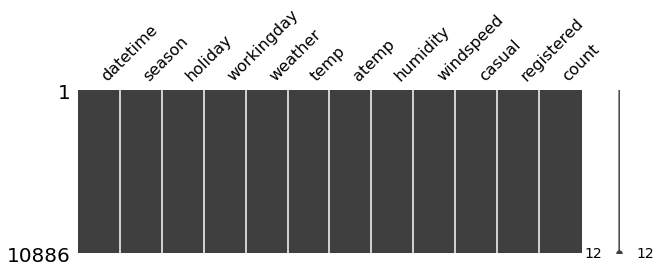

In [3]:
msno.matrix(df, figsize=(10,3))

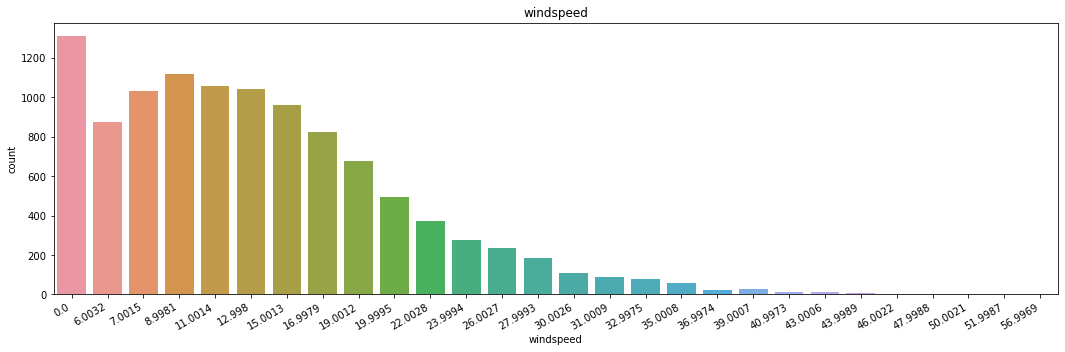

In [4]:
# Fix the wrong value: windspeed has too many data of zeros
fig, axes = plt.subplots()
fig.set_size_inches(18,5)

plt.sca(axes)
plt.xticks(rotation=30, ha='right')
axes.set(ylabel='Count',title="windspeed")
sns.countplot(data=df, x="windspeed", ax=axes)

In [5]:
# Change zero value of windspeed to mean value
df.loc[df["windspeed"] == 0, "windspeed"] = df["windspeed"].mean()


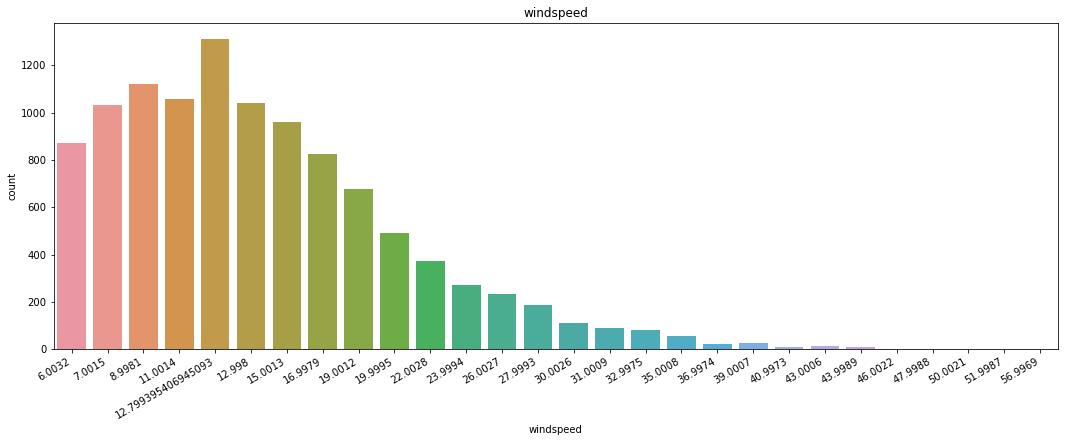

In [6]:
# Visualize widspeed after fixing value of zero
fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
ax1.set(ylabel='Count',title="windspeed")
sns.countplot(data=df, x="windspeed", ax=ax1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


# correlation

In [8]:
corrMatt = df[["temp", "atemp", "casual", "registered", "humidity", "windspeed", "count"]]
corrMatt = corrMatt.corr()
print(corrMatt)

mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

                temp     atemp    casual  registered  humidity  windspeed  \
temp        1.000000  0.984948  0.467097    0.318571 -0.064949  -0.034608   
atemp       0.984948  1.000000  0.462067    0.314635 -0.043536  -0.065606   
casual      0.467097  0.462067  1.000000    0.497250 -0.348187   0.084128   
registered  0.318571  0.314635  0.497250    1.000000 -0.265458   0.074258   
humidity   -0.064949 -0.043536 -0.348187   -0.265458  1.000000  -0.314752   
windspeed  -0.034608 -0.065606  0.084128    0.074258 -0.314752   1.000000   
count       0.394454  0.389784  0.690414    0.970948 -0.317371   0.085119   

               count  
temp        0.394454  
atemp       0.389784  
casual      0.690414  
registered  0.970948  
humidity   -0.317371  
windspeed   0.085119  
count       1.000000  


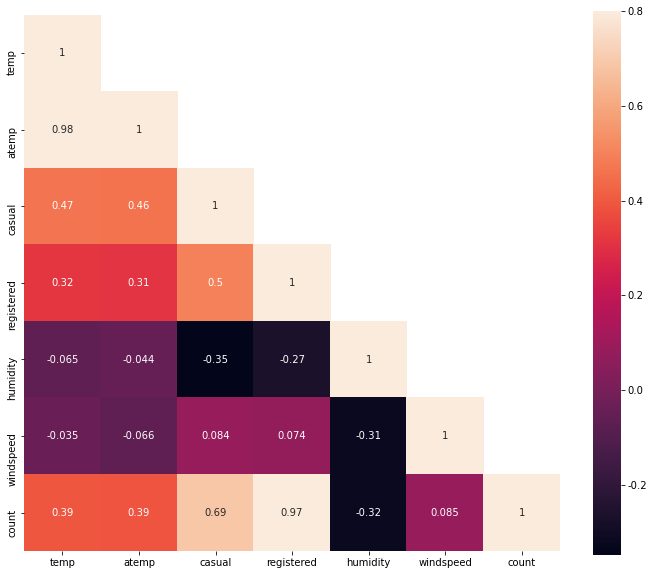

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(12,10)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

<h3>
<font color=blue>Correlation</font>
</h3>

- atemp & temp has the strongest relationship.

- registered feature has ths most impact on counts.

- temp, humidity and windspeed doesn't have relationship.

# 1. Can we tell the season by temp, weather, humidity, windspeed?(Decision Tree)

In [10]:
# predictor features: ['temp', 'humidity', 'windspeed]
X = df.drop(columns=['datetime', 'holiday', 'workingday', 'season', 'casual', 'registered', 'atemp', 'count'])

# label/target variable
y = df['season']

In [11]:
# Dividing data into two subsets :train and test set.Training set trains the model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# # # Data normalization  
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# # scaler.fit(X_train)

# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)


In [12]:
# Define DecisionTreeClassifier and train
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

### Accuracy

<h>
    <font color=blue>
        The accuracy on trainin set shows around 83% but the test set shows less that 60%.
    </font>
</h>

In [13]:
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 0.885
Accuracy on test set: 0.576


### Tree

<h>
    <font color=blue>
        Change the depth of the tree to 3 for better visualizaion. (It causes decreasing of accuracy)
    </font>
</h>

In [14]:


# tree_img = DecisionTreeClassifier(max_depth=3, random_state=0)
# tree_img.fit(X_train, y_train)
# out_file = export_graphviz(
#     tree_img, 
#     feature_names=X.columns, 
#     class_names=['spring', 'summer', 'fall', 'winter'], 
#     rounded=True, 
#     filled=True, 
#     impurity=True)

# graph = pydotplus.graph_from_dot_data(out_file)
# Image(graph.create_png())

### Feature importance

<h>
    <font color=blue>
        Temperature feature is the most important with 50% value as expected
    </font>
</h>

In [15]:
print("Feature importances:")
print(tree.feature_importances_)

Feature importances:
[0.0604458  0.49428767 0.22468245 0.22058407]


In [16]:
df_imp = pd.DataFrame(list(zip(X.columns, tree.feature_importances_)), columns=['feature', 'importance']).sort_values('importance', ascending=False)
df_imp = df_imp.reset_index(drop=True)
df_imp

,feature,importance
0,temp,0.494288
1,humidity,0.224682
2,windspeed,0.220584
3,weather,0.060446


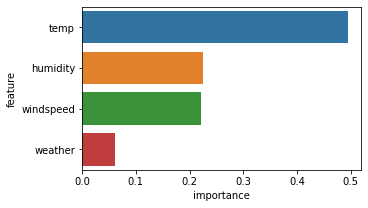

In [17]:
plt.figure(figsize=(5, 3))
sns.barplot(y='feature', x='importance', data=df_imp)
plt.show()

# 2. Predict the number of rentals

In [18]:
df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,12.799395,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,12.799395,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,12.799395,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,12.799395,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,12.799395,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.002700,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.001300,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.001300,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.003200,12,117,129


<h>
    <font color=blue>
        Split datetime value to year, month, day, hour, minute, second and day of week for better prediction
    </font>
</h>

In [19]:
# df["year"] = df["datetime"].dt.year
# df["month"] = df["datetime"].dt.month
# df["day"] = df["datetime"].dt.day
# df["hour"] = df["datetime"].dt.hour
# df["minute"] = df["datetime"].dt.minute
# df["second"] = df["datetime"].dt.second
# df["dayofweek"] = df["datetime"].dt.dayofweek
# df.info()

In [20]:
# continuous feature & categorical feature 
# continuous feature = ["temp","humidity","windspeed","atemp"]
# categorical feature: change the type to "category"
# categorical_feature_names = ["season","holiday","workingday","weather",
#                              "dayofweek","month","year","hour"]
categorical_feature_names = ["season","holiday","workingday","weather"]

for var in categorical_feature_names:
    df[var] = df[var].astype("category")

df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,12.799395,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,12.799395,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,12.799395,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,12.799395,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,12.799395,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.002700,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.001300,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.001300,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.003200,12,117,129


In [21]:
# Dividing data into two subsets :train and test set.Training set trains the model
# feature_names = ["season", "weather", "temp", "atemp", "humidity", "windspeed",
#                   "year", "hour", "dayofweek", "holiday", "workingday"]
feature_names1 = ["season", "weather", "temp", "atemp", "humidity", "windspeed",
                  "casual", "registered"]
df_x = df[feature_names1]
df_y = df[['count']]

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(df_x, df_y, test_size=0.20)

### Random Forest

In [22]:
from sklearn.ensemble import RandomForestRegressor
max_depth_list = []

model = RandomForestRegressor(n_estimators=100,
                              n_jobs=-1,
                              random_state=0)
# Train the model using train data
model.fit(X_train_1, y_train_1)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [23]:
# Prediction
predictions = model.predict(X_test_1)

print(predictions.shape)
predictions[0:10]

(2178,)


array([ 92.93,  33.95, 422.62,   5.  , 527.34,  83.55,   6.  , 387.99,
       346.22, 139.56])

<h>
    <font color=blue>
        For better understanding, visualized the comparison of actual data(train data) and predicted data.  <br>      
        ・The value is slightly different but the shapy is almost same.
    </font>
</h>

[Text(0.5, 1.0, 'Prediction')]

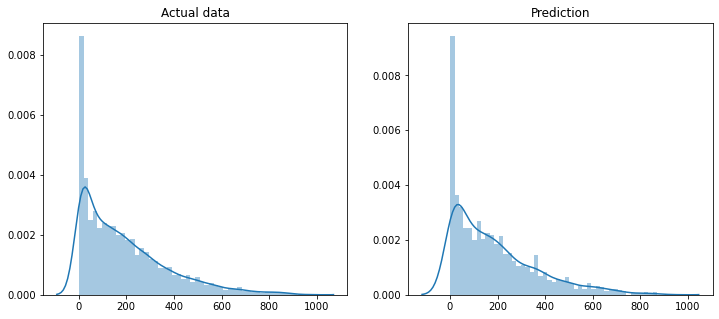

In [24]:
# Visualize the predition result
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train_1,ax=ax1,bins=50)
ax1.set(title="Actual data")
sns.distplot(predictions,ax=ax2,bins=50)
ax2.set(title="Prediction")

In [25]:
predictions = np.around(predictions.flatten()).astype("int")
predictions

array([ 93,  34, 423, ..., 434, 246, 353])

### Evaluation using MAE, MSE and RMSE

In [26]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
mae = mean_absolute_error(y_test_1, predictions)
mse = mean_squared_error(y_test_1, predictions)
rmse = mean_squared_error(y_test_1, predictions, squared=False)
print(round(mae, 2))
print(round(mse, 2))
print(round(rmse, 2))

1.11
6.48
2.55


### Predict rentals with conditions below
- season: 1=spring
- weather: 1=Clear
- temp: 12.8
- atemp: 11.1
- humidity: 75
- windspeed: 28.0022
- datetime 
    - year: 2012
    - hour: 16
    - dayofweek: 4=Thursday
- holiday: 1=yes
- workingday: 0=no

In [27]:
# prediction function
def make_df(season, weather, temp, atemp, humidity, windspeed, casual, registered):
    return pd.DataFrame({"season":[season], "weather":[weather], "temp":[temp], "atemp":[atemp], "humidity":[humidity], "windspeed":[windspeed], "casual":[casual], "registered":[registered]})

# data prediction

In [28]:
season, weather, temp, atemp, humidity, windspeed, casual, registered = 2, 1, 25.42, 30.305, 69, 15.0013, 64, 463
result = int(model.predict(make_df(season, weather, temp, atemp, humidity, windspeed, casual, registered)).flatten()[0])
result

526



---




# 3. Predict the number of rentals using:
    - Temperature
    - Registered
    - Humidity


In [29]:
# import pandas as pd  
# import numpy as np  
# import matplotlib.pyplot as plt  
# from sklearn import linear_model
# import seaborn as sb
# import scipy.stats as stat
# from pandas.plotting import scatter_matrix
# from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
# from sklearn import metrics
# import seaborn as sns


# %matplotlib inline

In [30]:
df.describe().round(2)

,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00
mean,20.23,23.66,61.89,14.34,36.02,155.55,191.57
std,7.79,8.47,19.25,6.67,49.96,151.04,181.14
min,0.82,0.76,0.00,6.00,0.00,0.00,1.00
25%,13.94,16.66,47.00,9.00,4.00,36.00,42.00
50%,20.50,24.24,62.00,13.00,17.00,118.00,145.00
75%,26.24,31.06,77.00,17.00,49.00,222.00,284.00
max,41.00,45.46,100.00,57.00,367.00,886.00,977.00


In [31]:
df.corr()

,temp,atemp,humidity,windspeed,casual,registered,count
temp,1.000000,0.984948,-0.064949,-0.034608,0.467097,0.318571,0.394454
atemp,0.984948,1.000000,-0.043536,-0.065606,0.462067,0.314635,0.389784
humidity,-0.064949,-0.043536,1.000000,-0.314752,-0.348187,-0.265458,-0.317371
windspeed,-0.034608,-0.065606,-0.314752,1.000000,0.084128,0.074258,0.085119
casual,0.467097,0.462067,-0.348187,0.084128,1.000000,0.497250,0.690414
registered,0.318571,0.314635,-0.265458,0.074258,0.497250,1.000000,0.970948
count,0.394454,0.389784,-0.317371,0.085119,0.690414,0.970948,1.000000


"Count" is the Y value (dependent variable)

"Temp", "Registered" and "Humidity" is the X value (independent variable)

In [32]:
y = df['count']

In [33]:
X = df[['temp', 'registered', 'humidity']]

In [34]:
# 20% of dataset is test, 80% train

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [35]:
# Train has 8708 values and 3 columns

X_train.shape

(8708, 3)

In [36]:
# Test has 2178 values and 3 columns

X_test.shape

(2178, 3)

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics


lin_model = LinearRegression()
log_model = 

In [38]:
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [39]:
print('Variance Score: %0.2f' % model.score(X_train, y_train))

Variance Score: 0.95


In [40]:
y_pred = model.predict(X_test)

In [41]:
print('Variance Score = %s' %metrics.r2_score(y_test, y_pred).round(2))

Variance Score = 0.96


In [42]:
from sklearn import metrics  
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error: ', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 24.00684009860548
Mean Squared Error:  1423.963388133874
Root Mean Squared Error: 37.73543941885233


In [43]:
#Predicting
entry = X_test[0:1] 
entry

,temp,registered,humidity
6495,18.04,177,62


In [44]:
model.predict(entry)[0]

210.3997690525341

In [45]:
#predicting values using model

temp=18.04
registered=177
humidity=62
entry=[[temp, registered, humidity]]
print('{0:.2f}'.format(model.predict(entry)[0]))

210.40


In [46]:
model.intercept_

13.267991214519554

In [47]:
model.coef_

array([ 2.24831774,  1.10456176, -0.6279888 ])

In [48]:
X.columns

Index(['temp', 'registered', 'humidity'], dtype='object')

In [49]:
index=['Intercept','temp', 'registered', 'humidity']

In [50]:
#Create a dataframe with coefficient values

pd.DataFrame(data=np.append(model.intercept_, model.coef_), index=index, columns={'Coefficients'})

,Coefficients
Intercept,13.267991
temp,2.248318
registered,1.104562
humidity,-0.627989


In [51]:
#Show Prediction vs Actual 
y_pred_train = model.predict(X_train)

In [52]:
y_pred_train.shape

(8708,)

In [53]:
y_train.shape

(8708,)

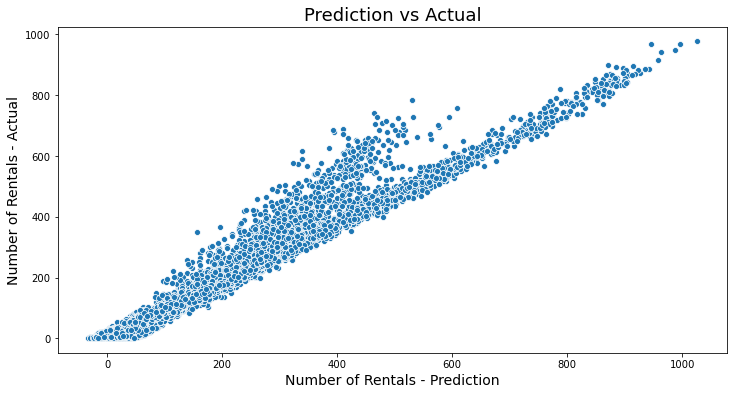

In [54]:
ax=sns.scatterplot(x=y_pred_train, y=y_train)
ax.figure.set_size_inches(12, 6)
ax.set_title('Prediction vs Actual', fontsize=18)
ax.set_xlabel('Number of Rentals - Prediction', fontsize=14)
ax.set_ylabel('Number of Rentals - Actual', fontsize=14)
ax